In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import warnings
warnings.filterwarnings("ignore")

In [ ]:
msft_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Microsoft_stock.csv')

# Checking with Microsoft Stock
print("Checking with Microsoft Stock:\n")
msft_stock

Checking with Microsoft Stock:



,Date,Adj Close,Stock Name
0,2013-01-02,22.321140,MSFT
1,2013-01-03,22.022121,MSFT
2,2013-01-04,21.609970,MSFT
3,2013-01-07,21.569563,MSFT
4,2013-01-08,21.456419,MSFT
...,...,...,...
3013,2024-12-20,434.927856,MSFT
3014,2024-12-23,433.583038,MSFT
3015,2024-12-24,437.647369,MSFT
3016,2024-12-26,436.432068,MSFT


### Evaluation of Microsoft Stock with 80% Training and 20% Testing

In [ ]:
msft_stock['Date'] = pd.to_datetime(msft_stock['Date'])
msft_stock.sort_values('Date', inplace=True)

In [ ]:
# Use Adj closing price and create train-test split
msft_prices = msft_stock['Adj Close'].values
train_size = int(len(msft_prices) * 0.8)
train, test = msft_prices[:train_size], msft_prices[train_size:]

print(f"80% of Microsoft Training Stocks size: {len(train)}")
print(f"20% of Microsoft Testing Stocks  size: {len(test)}")

80% of Microsoft Training Stocks size: 2414
20% of Microsoft Testing Stocks  size: 604


In [ ]:
train

array([ 22.32114029,  22.02212143,  21.60997009, ..., 271.13244629,
       268.02130127, 275.4821167 ])

In [ ]:
test

array([276.63287354, 275.91119385, 273.38522339, 275.3163147 ,
       282.0065918 , 279.91955566, 284.6885376 , 286.20996094,
       285.46875   , 284.71621704, 283.59234619, 279.6633606 ,
       271.4538269 , 270.17352295, 269.53826904, 272.52893066,
       262.01278687, 259.21762085, 257.0088501 , 255.54284668,
       254.49711609, 250.25547791, 247.50923157, 252.23948669,
       252.65974426, 258.46508789, 260.60543823, 246.277771  ,
       246.50254822, 239.81762695, 239.19210815, 238.97709656,
       236.95404053, 233.53334045, 235.51733398, 232.52668762,
       232.06735229, 231.05093384, 235.60533142, 232.11624146,
       227.6204834 , 235.28277588, 243.23828125, 243.55101013,
       241.19564819, 228.93014526, 224.05323792, 220.30032349,
       220.63258362, 228.93014526, 223.37889099, 232.14555359,
       233.09358215, 231.11935425, 230.79685974, 236.63150024,
       241.64520264, 244.97792053, 226.07633972, 221.60993958,
       230.52316284, 226.86798096, 222.99769592, 215.11

Stationarity Check for ARIMA Model

In [ ]:
# Stationarity check when the series are stationary
def make_series_stationary(series, max_diffs=2):
    current_series = series.copy()
    diffs_applied = 0

    for i in range(max_diffs + 1):
        # Perform Dickey-Fuller test
        result = adfuller(current_series)
        p_value = result[1]

        print(f"\nTest {i+1}:")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {p_value:.4f}")
        print("Critical Values:")
        for key, value in result[4].items():
            print(f"\t{key}: {value:.4f}")

        if p_value <= 0.05:
            print("\nSeries is now stationary")
            return current_series, diffs_applied
        elif i < max_diffs:
            print("\nSeries is not stationary. Applying differencing...")
            current_series = np.diff(current_series)
            diffs_applied += 1

    raise ValueError(f"Series could not be made stationary after {max_diffs} differences")

# Make the training series stationary
try:
    print("Checking stationarity of original series...")
    train_stationary, diffs_needed = make_series_stationary(train)

    print(f"\nSuccessfully made series stationary with {diffs_needed} difference(s)")
    print("Proceeding with next steps...")

except ValueError as e:
    print(f"\nError: {e}")
    print("Cannot proceed with analysis - series is not stationary")

Checking stationarity of original series...

Test 1:
ADF Statistic: 0.6612
p-value: 0.9890
Critical Values:
	1%: -3.4331
	5%: -2.8627
	10%: -2.5674

Series is not stationary. Applying differencing...

Test 2:
ADF Statistic: -14.1380
p-value: 0.0000
Critical Values:
	1%: -3.4331
	5%: -2.8627
	10%: -2.5674

Series is now stationary

Successfully made series stationary with 1 difference(s)
Proceeding with next steps...


Text(0.5, 1.0, 'ACF - Original Series')

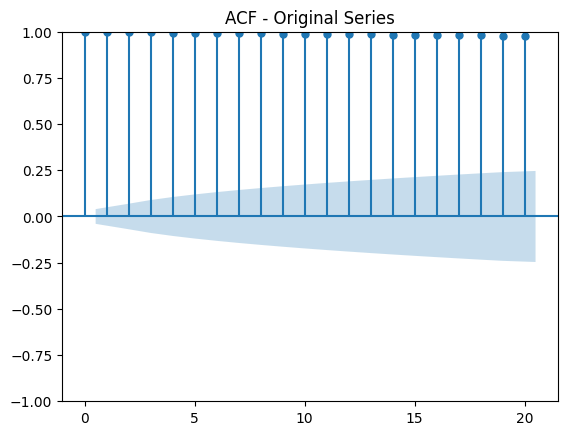

In [ ]:
# ACF and PACF plots for original series
plot_acf(train, lags=20)
plt.title('ACF - Original Series')

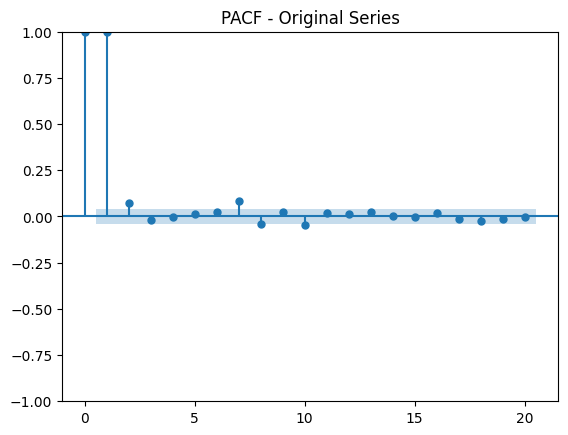

In [ ]:
plot_pacf(train, lags=20, method='ywm')
plt.title('PACF - Original Series')
plt.show()

Text(0.5, 1.0, 'ACF - Differenced Series')

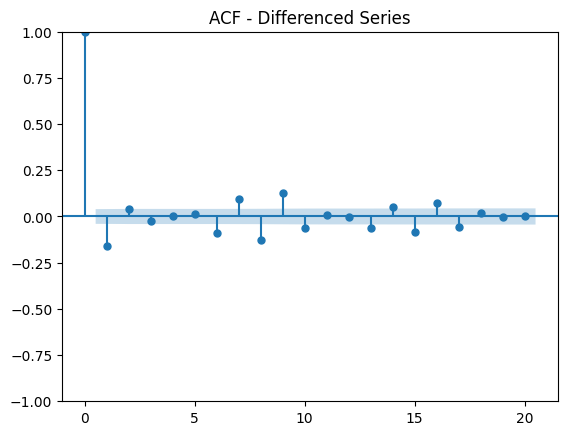

In [ ]:
plot_acf(train_stationary, lags=20)
plt.title('ACF - Differenced Series')

Text(0.5, 1.0, 'PACF - Differenced Series')

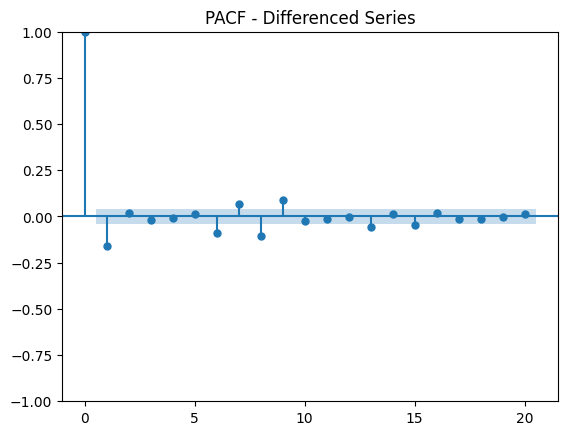

In [ ]:
plot_pacf(train_stationary, lags=20, method='ywm')
plt.title('PACF - Differenced Series')

#### ARIMA Model for 80-20

In [ ]:
# Evaluate ARIMA model
def evaluate_arima_model(train, test, order):
    history = [x for x in train]
    predictions = list()

    # Walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # Performance metrics
    r2 = r2_score(test, predictions)
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)

    return predictions, r2, mae, mse, rmse

In [ ]:
# Try different ARIMA orders based on ACF/PACF analysis
orders_to_try = [
    (1,0,1),  # Standard starting point
    (2,1,2),  # More complex model
    (0,1,1),  # MA only
    (1,1,0),  # AR only
    (5,1,0),  # Higher AR
    (0,1,5),  # Higher MA
]

best_r2 = -np.inf
best_order = None
best_predictions = None

for order in orders_to_try:
    try:
        print(f"\nEvaluating ARIMA{order}...")
        predictions, r2, mae, mse, rmse = evaluate_arima_model(train, test, order)
        print(f"R²: {r2:.4f}| MAE: {mae:.4f}| MSE: {mse:.4f}| RMSE: {rmse:.4f}")

        if r2 > best_r2:
            best_r2 = r2
            best_order = order
            best_predictions = predictions
    except:
        continue

print(f"\nBest model: ARIMA{best_order} with R²: {best_r2:.4f}")


Evaluating ARIMA(1, 0, 1)...
R²: 0.9952| MAE: 3.8462| MSE: 25.7596| RMSE: 5.0754

Evaluating ARIMA(2, 1, 2)...
R²: 0.9951| MAE: 3.8544| MSE: 25.9113| RMSE: 5.0903

Evaluating ARIMA(0, 1, 1)...
R²: 0.9952| MAE: 3.8443| MSE: 25.7368| RMSE: 5.0731

Evaluating ARIMA(1, 1, 0)...
R²: 0.9952| MAE: 3.8489| MSE: 25.7995| RMSE: 5.0793

Evaluating ARIMA(5, 1, 0)...
R²: 0.9952| MAE: 3.8423| MSE: 25.7712| RMSE: 5.0765

Evaluating ARIMA(0, 1, 5)...
R²: 0.9951| MAE: 3.8457| MSE: 25.8137| RMSE: 5.0807

Best model: ARIMA(0, 1, 1) with R²: 0.9952


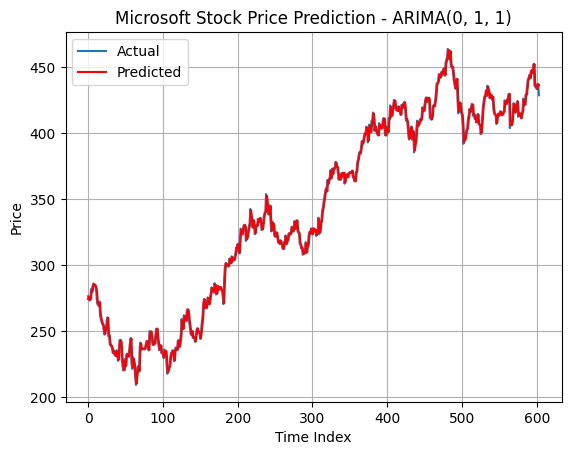

In [16]:
# Plot best model results
plt.plot(test, label='Actual', )
plt.plot(best_predictions, color='red', label='Predicted')
plt.title(f'Microsoft Stock Price Prediction - ARIMA{best_order}')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Print metrics for best model
print("\n=== Best Model Performance ===")
print(f"ARIMA Order: {best_order}")
print(f"ARIMA - R² Score: {best_r2:.4f}")
print(f"ARIMA - MAE     : {mean_absolute_error(test, best_predictions):.4f}")
print(f"ARIMA - MSE     : {mean_squared_error(test, best_predictions):.4f}")
print(f"ARIMA - RMSE    : {np.sqrt(mean_squared_error(test, best_predictions)):.4f}")


=== Best Model Performance ===
ARIMA Order: (0, 1, 1)
ARIMA - R² Score: 0.9952
ARIMA - MAE     : 3.8443
ARIMA - MSE     : 25.7368
ARIMA - RMSE    : 5.0731


In [18]:
def cumulative_return(prices):
    return (prices / prices[0]) - 1

## Convert forecast and test_series to NumPy arrays for calculating cumulative return
forecast_arima = np.array(best_predictions)
test_series_array = np.array(test)

cum_return_actual_arima = cumulative_return(test_series_array)
cum_return_pred_arima = cumulative_return(forecast_arima)

# Print first 10 predictions vs actual
print("\nFirst 10 Predictions vs Actual:")
for i in range(10):
    print(f"Day {i+1}: Actual = {test[i]:.2f}, Predicted = {best_predictions[i]:.2f}")


First 10 Predictions vs Actual:
Day 1: Actual = 276.63, Predicted = 274.45
Day 2: Actual = 275.91, Predicted = 276.31
Day 3: Actual = 273.39, Predicted = 275.97
Day 4: Actual = 275.32, Predicted = 273.77
Day 5: Actual = 282.01, Predicted = 275.09
Day 6: Actual = 279.92, Predicted = 280.99
Day 7: Actual = 284.69, Predicted = 280.08
Day 8: Actual = 286.21, Predicted = 284.01
Day 9: Actual = 285.47, Predicted = 285.89
Day 10: Actual = 284.72, Predicted = 285.53


#### LSTM Model for 80-20

In [19]:
scaler = RobustScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1)) # Fit and transform only on train data
test_scaled = scaler.transform(test.reshape(-1, 1)) # Transform test data using the scaler fitted on train

# Create sequences
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X_train, y_train = create_sequences(train_scaled, time_steps)
X_test, y_test = create_sequences(test_scaled, time_steps)

# Match original test length
actual_test = test[time_steps:]

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

=== LSTM Model Performance ===
LSTM - R² Score: 0.9856
LSTM - MAE     : 6.8297
LSTM - MSE     : 77.0717
LSTM - RMSE    : 8.7791


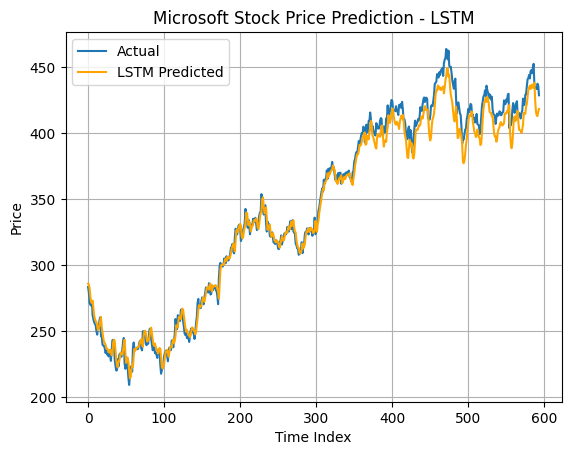


First 10 Predictions vs Actual (LSTM):
Day 1: Actual = 283.59, Predicted = 286.17
Day 2: Actual = 279.66, Predicted = 285.34
Day 3: Actual = 271.45, Predicted = 282.56
Day 4: Actual = 270.17, Predicted = 276.18
Day 5: Actual = 269.54, Predicted = 272.52
Day 6: Actual = 272.53, Predicted = 271.52
Day 7: Actual = 262.01, Predicted = 273.27
Day 8: Actual = 259.22, Predicted = 267.75
Day 9: Actual = 257.01, Predicted = 262.01
Day 10: Actual = 255.54, Predicted = 259.34


In [20]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

# Prediction
lstm_preds_scaled = lstm_model.predict(X_test)
lstm_preds = scaler.inverse_transform(lstm_preds_scaled)
lstm_preds = lstm_preds.flatten()

# Evaluation
r2_lstm = r2_score(actual_test, lstm_preds)
mae_lstm = mean_absolute_error(actual_test, lstm_preds)
mse_lstm = mean_squared_error(actual_test, lstm_preds)
rmse_lstm = np.sqrt(mse_lstm)

print("\n=== LSTM Model Performance ===")
print(f"LSTM - R² Score: {r2_lstm:.4f}")
print(f"LSTM - MAE     : {mae_lstm:.4f}")
print(f"LSTM - MSE     : {mse_lstm:.4f}")
print(f"LSTM - RMSE    : {rmse_lstm:.4f}")

# Cumulative return
def cumulative_return(prices):
    return (prices / prices[0]) - 1

cum_return_actual_lstm = cumulative_return(actual_test)
cum_return_pred_lstm = cumulative_return(lstm_preds)

# Plot
plt.plot(actual_test, label='Actual')
plt.plot(lstm_preds, color='orange', label='LSTM Predicted')
plt.title('Microsoft Stock Price Prediction - LSTM')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print first 10
print("\nFirst 10 Predictions vs Actual (LSTM):")
for i in range(10):
    print(f"Day {i+1}: Actual = {actual_test[i]:.2f}, Predicted = {lstm_preds[i]:.2f}")

#### GRU Model for 80-20

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

=== GRU Model Performance ===
GRU - R² Score: 0.9946
GRU - MAE     : 4.1939
GRU - MSE     : 28.6621
GRU - RMSE    : 5.3537


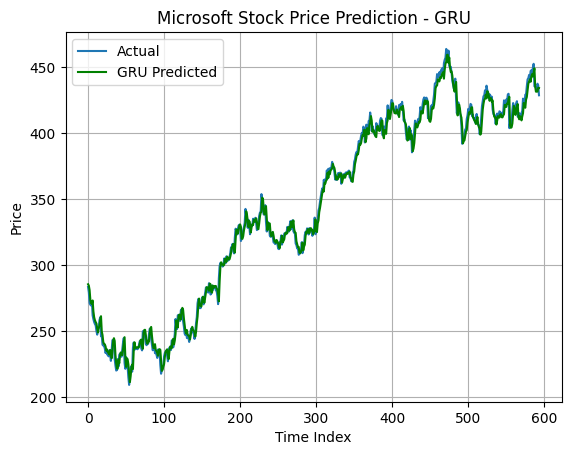


First 10 Predictions vs Actual (GRU):
Day 1: Actual = 283.59, Predicted = 285.66
Day 2: Actual = 279.66, Predicted = 284.64
Day 3: Actual = 271.45, Predicted = 281.29
Day 4: Actual = 270.17, Predicted = 273.78
Day 5: Actual = 269.54, Predicted = 271.31
Day 6: Actual = 272.53, Predicted = 270.82
Day 7: Actual = 262.01, Predicted = 273.37
Day 8: Actual = 259.22, Predicted = 265.14
Day 9: Actual = 257.01, Predicted = 260.68
Day 10: Actual = 255.54, Predicted = 258.40


In [21]:
# GRU Model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

# Prediction
gru_preds_scaled = gru_model.predict(X_test)
gru_preds = scaler.inverse_transform(gru_preds_scaled)
gru_preds = gru_preds.flatten()

# Evaluation
r2_gru = r2_score(actual_test, gru_preds)
mae_gru = mean_absolute_error(actual_test, gru_preds)
mse_gru = mean_squared_error(actual_test, gru_preds)
rmse_gru = np.sqrt(mse_gru)

print("\n=== GRU Model Performance ===")
print(f"GRU - R² Score: {r2_gru:.4f}")
print(f"GRU - MAE     : {mae_gru:.4f}")
print(f"GRU - MSE     : {mse_gru:.4f}")
print(f"GRU - RMSE    : {rmse_gru:.4f}")

# Cumulative return
cum_return_actual_gru = cumulative_return(actual_test)
cum_return_pred_gru = cumulative_return(gru_preds)

# Plot
plt.plot(actual_test, label='Actual')
plt.plot(gru_preds, color='green', label='GRU Predicted')
plt.title('Microsoft Stock Price Prediction - GRU')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print first 10
print("\nFirst 10 Predictions vs Actual (GRU):")
for i in range(10):
    print(f"Day {i+1}: Actual = {actual_test[i]:.2f}, Predicted = {gru_preds[i]:.2f}")

In [22]:
print("\n=== Model Comparison Summary ===")
print(f"ARIMA → R²: {best_r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
print(f"LSTM  → R²: {r2_lstm:.4f}, MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")
print(f"GRU   → R²: {r2_gru:.4f}, MAE: {mae_gru:.4f}, RMSE: {rmse_gru:.4f}")



=== Model Comparison Summary ===
ARIMA → R²: 0.9952, MAE: 3.8457, RMSE: 5.0807
LSTM  → R²: 0.9856, MAE: 6.8297, RMSE: 8.7791
GRU   → R²: 0.9946, MAE: 4.1939, RMSE: 5.3537


### Evaluation of 10 years Stock as Training and 3 months Stock as Testing

In [25]:
msft_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Microsoft_stock.csv')
three_months_stock = pd.read_csv('/content/drive/MyDrive/Stocks Data/Microsoft3Months_Stock.csv')

print("10 years Microsoft Stock for Training:", msft_stock.shape)
print("3 months Microsoft Stock for Testing :", three_months_stock.shape)

10 years Microsoft Stock for Training: (3018, 3)
3 months Microsoft Stock for Testing : (59, 3)


In [26]:
three_months_stock

,Date,Adj Close,Stock Name
0,2025-01-02,416.976868,MSFT_3Months
1,2025-01-03,421.728607,MSFT_3Months
2,2025-01-06,426.211365,MSFT_3Months
3,2025-01-07,420.752350,MSFT_3Months
4,2025-01-08,422.933960,MSFT_3Months
5,2025-01-10,417.345459,MSFT_3Months
6,2025-01-13,415.592194,MSFT_3Months
7,2025-01-14,414.078033,MSFT_3Months
8,2025-01-15,424.677246,MSFT_3Months
9,2025-01-16,422.953857,MSFT_3Months


In [27]:
# Date Conversion
msft_stock['Date'] = pd.to_datetime(msft_stock['Date'])
three_months_stock['Date'] = pd.to_datetime(three_months_stock['Date'])

# Sort data
msft_stock.sort_values('Date', inplace=True)
three_months_stock.sort_values('Date', inplace=True)

# Extract series
train_msft = msft_stock['Adj Close'].values
three_months_test = three_months_stock['Adj Close'].values
three_months_dates = three_months_stock['Date'].values

In [ ]:
train_msft

array([ 22.32114601,  22.02212906,  21.60996628, ..., 437.6473999 ,
       436.43206787, 428.88110352])

In [ ]:
three_months_test

array([416.97686768, 421.72860718, 426.21136475, 420.75234985,
       422.93395996, 417.34545898, 415.5921936 , 414.07803345,
       424.67724609, 422.95385742, 427.38684082, 426.85888672,
       444.49108887, 444.99911499, 442.35928345, 432.8956604 ,
       445.48727417, 440.63589478, 413.40060425, 413.47033691,
       409.34622192, 410.79064941, 411.7071228 , 414.22744751,
       408.18069458, 410.64120483, 409.86419678, 407.47338867,
       408.96765137, 406.86572266, 408.07110596, 413.181427  ,
       415.36746216, 407.46194458, 403.25967407, 397.1708374 ,
       398.99749756, 391.81069946, 396.26251221, 387.77807617,
       387.89785767, 400.28512573, 396.16271973, 392.58926392,
       379.46337891, 379.75283813, 382.56765747, 378.07589722,
       387.84796143, 387.98773193, 382.81719971, 387.10934448,
       386.13110352, 390.54302979, 392.35968018, 394.43588257,
       389.25540161, 389.86425781, 378.10583496])

#### ARIMA Model for 3 months Prediction

In [28]:
# Use best order from earlier results
best_order = (0, 1, 1)

# Walk-forward forecast for next 3 months
history = list(train_msft)
predictions = []

for t in range(len(three_months_test)):
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(three_months_test[t])  # Update with actual value (if simulating walk-forward)

# Evaluation
r2_arima = r2_score(three_months_test, predictions)
mae_arima = mean_absolute_error(three_months_test, predictions)
mse_arima = mean_squared_error(three_months_test, predictions)
rmse_arima = np.sqrt(mse_arima)

print("\nARIMA Evaluation:")
print(f"R²: {r2_arima:.4f} | MAE: {mae_arima:.4f} | MSE: {mse_arima:.4f} | RMSE: {rmse_arima:.4f}")


ARIMA Evaluation:
R²: 0.8543 | MAE: 4.8901 | MSE: 47.4559 | RMSE: 6.8888


In [30]:
# Calculate cumulative returns
def calculate_cumulative_returns(prices):
    return (prices / prices[0] - 1) * 100

actual_returns = calculate_cumulative_returns(three_months_test)
predicted_returns = calculate_cumulative_returns(predictions)

# Results dataframe
results = pd.DataFrame({
    'Date': three_months_dates,
    'Actual Price': three_months_test,
    'Predicted Price': predictions,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})

In [31]:
# Display results
print("3 Months Microsoft Stock - Actual vs Predicted:")
results.head()

3 Months Microsoft Stock - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,416.976868,429.567732,0.000000,0.000000
1,2025-01-03,421.728607,418.065481,1.139569,-2.677634
2,2025-01-06,426.211365,421.407038,2.214631,-1.899746
3,2025-01-07,420.752350,425.789110,0.905442,-0.879634
4,2025-01-08,422.933960,421.199181,1.428639,-1.948133


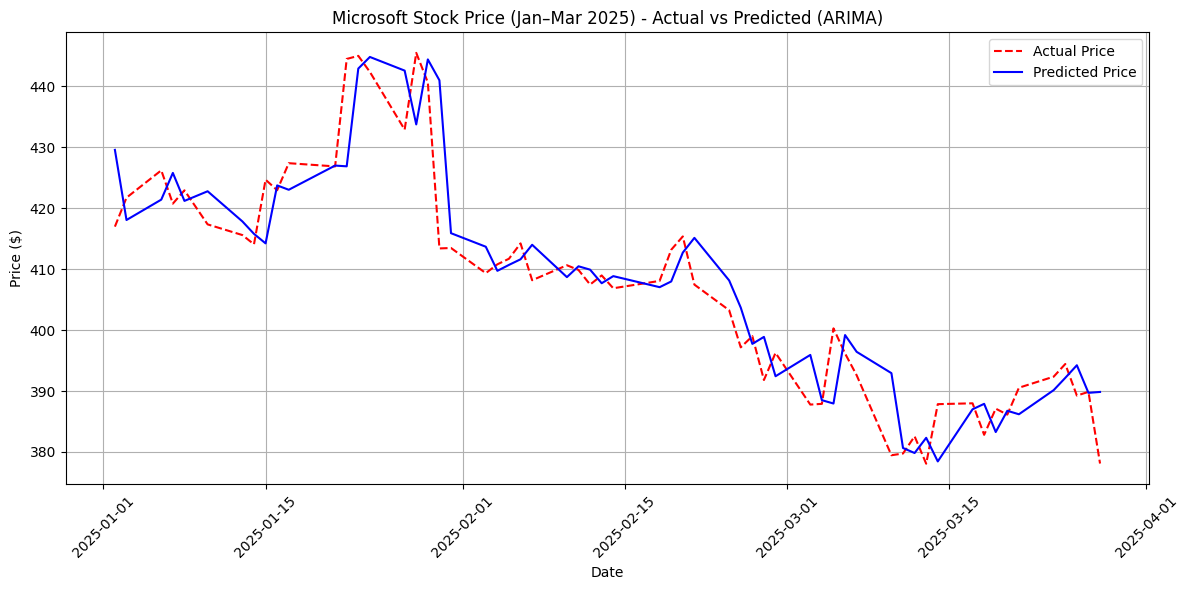

In [32]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual Price'], 'r--', label='Actual Price')  # Dotted
plt.plot(results['Date'], results['Predicted Price'], 'b-', label='Predicted Price')
plt.title('Microsoft Stock Price (Jan–Mar 2025) - Actual vs Predicted (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### LSTM Model for 3 months Prediction

In [33]:
## Preparing data
full_series = msft_stock['Adj Close'].values.reshape(-1, 1)
test_series = three_months_stock['Adj Close'].values.reshape(-1, 1)
test_dates = three_months_stock['Date'].values

## Robust Scaling
scaler = RobustScaler()
scaled_full_series = scaler.fit_transform(full_series)

## Create sequences with timesteps = 10
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

## use all 3018 Apple stock for training
time_steps = 10
X_train, y_train = create_sequences(scaled_full_series, time_steps)

In [34]:
X_train

array([[[-0.38996772],
        [-0.39141441],
        [-0.39340844],
        ...,
        [-0.39305655],
        [-0.39282196],
        [-0.39157078]],

       [[-0.39141441],
        [-0.39340844],
        [-0.39360394],
        ...,
        [-0.39282196],
        [-0.39157078],
        [-0.39223546]],

       [[-0.39340844],
        [-0.39360394],
        [-0.39415134],
        ...,
        [-0.39157078],
        [-0.39223546],
        [-0.39141441]],

       ...,

       [[ 1.63870409],
        [ 1.66598297],
        [ 1.66872995],
        ...,
        [ 1.60834071],
        [ 1.60626833],
        [ 1.59976196]],

       [[ 1.66598297],
        [ 1.66872995],
        [ 1.65769317],
        ...,
        [ 1.60626833],
        [ 1.59976196],
        [ 1.61942563]],

       [[ 1.66872995],
        [ 1.65769317],
        [ 1.67851381],
        ...,
        [ 1.59976196],
        [ 1.61942563],
        [ 1.61354587]]])

In [35]:
## LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='tanh', input_shape=(time_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()  ## Starting input sequence from last 10 days of Walmart
input_sequences = []  ## To store each input sequence used
predictions = []      ## To store predictions

for i in range(len(test_series)):
    input_sequences.append(input_seq.copy())  ## Save current input sequence

    ## Prediction
    pred = lstm_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating input sequence with actual next price (walk-forward validation)
    next_actual_scaled = scaler.transform(test_series[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]


MSFT LSTM Evaluation:
R²: 0.8187 | MAE: 5.7373 | MSE: 59.0542 | RMSE: 7.6847


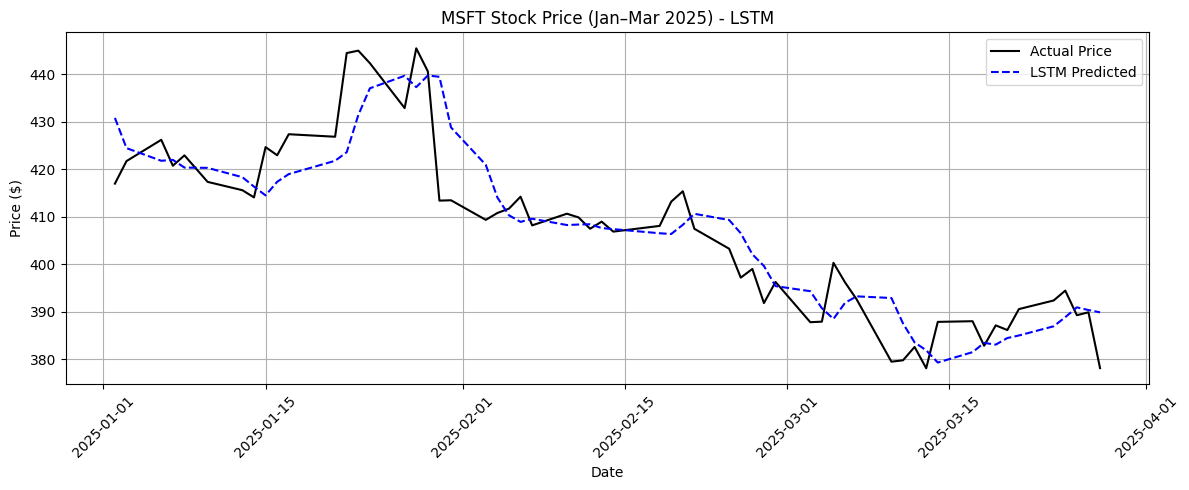


MSFT LSTM Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,416.976868,430.829163,0.000000,0.000000
1,2025-01-03,421.728607,424.459473,1.139569,-1.478469
2,2025-01-06,426.211365,421.793884,2.214631,-2.097183
3,2025-01-07,420.752350,421.982117,0.905442,-2.053493
4,2025-01-08,422.933960,420.363098,1.428639,-2.429283


In [36]:
## Inverse transform predictions
lstm_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_lstm = r2_score(three_months_test, lstm_predicted_prices)
mae_lstm = mean_absolute_error(three_months_test, lstm_predicted_prices)
mse_lstm = mean_squared_error(three_months_test, lstm_predicted_prices)
rmse_lstm = np.sqrt(mse_lstm)

print("\nMSFT LSTM Evaluation:")
print(f"R²: {r2_lstm:.4f} | MAE: {mae_lstm:.4f} | MSE: {mse_lstm:.4f} | RMSE: {rmse_lstm:.4f}")

## Cumulative return calculation
def calculate_cumulative_returns(prices):
    return (prices / prices[0] - 1) * 100

actual_returns = calculate_cumulative_returns(test_series.flatten())
predicted_returns = calculate_cumulative_returns(lstm_predicted_prices)

## Results
lstm_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series.flatten(),
    'Predicted Price': lstm_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})

plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series.flatten(), 'k-', label='Actual Price')
plt.plot(test_dates, lstm_results['Predicted Price'], 'b--', label='LSTM Predicted')
plt.title('MSFT Stock Price (Jan–Mar 2025) - LSTM')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nMSFT LSTM Model - Actual vs Predicted:")
lstm_results.head()

#### GRU Model for 3 months Prediction


MSFT GRU Evaluation:
R²: 0.8489 | MAE: 5.1611 | MSE: 49.2164 | RMSE: 7.0154


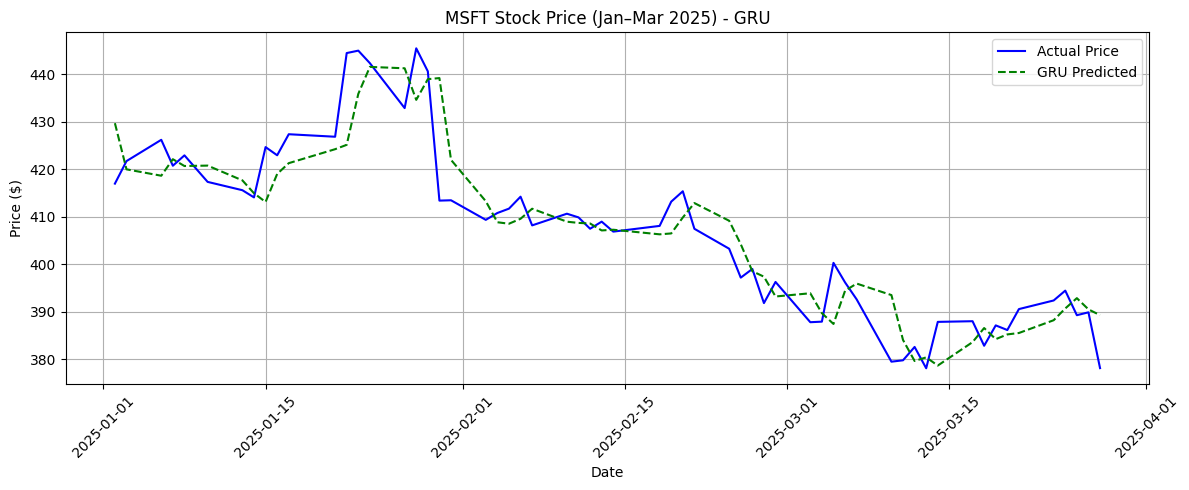


MSFT GRU Model - Actual vs Predicted:


,Date,Actual Price,Predicted Price,Actual Returns (%),Predicted Returns (%)
0,2025-01-02,416.976868,429.712219,0.000000,0.000000
1,2025-01-03,421.728607,419.990967,1.139569,-2.262270
2,2025-01-06,426.211365,418.644470,2.214631,-2.575618
3,2025-01-07,420.752350,422.123840,0.905442,-1.765919
4,2025-01-08,422.933960,420.690186,1.428639,-2.099550


In [37]:
## GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='tanh', input_shape=(time_steps, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

## Forecasting next 59 points using actual next price for walk-forward
input_seq = scaled_full_series[-time_steps:].copy()
input_sequences = []
predictions = []

for i in range(len(test_series)):
    input_sequences.append(input_seq.copy())

    ## Prediction
    pred = gru_model.predict(input_seq.reshape(1, time_steps, 1), verbose=0)
    predictions.append(pred[0][0])

    ## Updating sequence with actual next price
    next_actual_scaled = scaler.transform(test_series[i].reshape(1, -1))[0][0]
    input_seq = np.append(input_seq, next_actual_scaled)[-time_steps:]

## Inverse transform predictions
gru_predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

## Evaluation
r2_gru = r2_score(three_months_test, gru_predicted_prices)
mae_gru = mean_absolute_error(three_months_test, gru_predicted_prices)
mse_gru = mean_squared_error(three_months_test, gru_predicted_prices)
rmse_gru = np.sqrt(mse_gru)

print("\nMSFT GRU Evaluation:")
print(f"R²: {r2_gru:.4f} | MAE: {mae_gru:.4f} | MSE: {mse_gru:.4f} | RMSE: {rmse_gru:.4f}")

## Cumulative returns
actual_returns = calculate_cumulative_returns(test_series.flatten())
predicted_returns = calculate_cumulative_returns(gru_predicted_prices)

## Results
gru_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': test_series.flatten(),
    'Predicted Price': gru_predicted_prices,
    'Actual Returns (%)': actual_returns,
    'Predicted Returns (%)': predicted_returns
})

plt.figure(figsize=(12, 5))
plt.plot(test_dates, test_series.flatten(), 'b-', label='Actual Price')
plt.plot(test_dates, gru_results['Predicted Price'], 'g--', label='GRU Predicted')
plt.title('MSFT Stock Price (Jan–Mar 2025) - GRU')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nMSFT GRU Model - Actual vs Predicted:")
gru_results.head()